In [88]:
import os
import numpy as np
import pickle
import math
import scipy as sp
from scipy import interpolate
from numpy.linalg import solve
import matplotlib.pyplot as plt
from skimage.measure import profile_line
from time import time
import spekpy
import skimage
import copy

from cil.io import NikonDataReader, RAWFileWriter, TIFFStackReader, TIFFWriter
from cil.utilities.jupyter import islicer
from cil.utilities.display import show_geometry, show2D
from cil.recon import FDK
from cil.plugins.tigre import FBP, ProjectionOperator
from cil.processors import TransmissionAbsorptionConverter, Slicer, CentreOfRotationCorrector
from cil.optimisation.algorithms import CGLS, SIRT

from cil.optimisation.algorithms import GD, FISTA, PDHG
from cil.optimisation.operators import BlockOperator, GradientOperator,\
                                       GradientOperator
from cil.optimisation.functions import IndicatorBox, MixedL21Norm, L2NormSquared, \
                                       BlockFunction, L1Norm, LeastSquares, \
                                       OperatorCompositionFunction, TotalVariation, \
                                       ZeroFunction, IndicatorBox
from cil.plugins.ccpi_regularisation.functions import FGP_TV


from cil.io import NikonDataReader
from cil.utilities.jupyter import islicer
from cil.utilities.display import show_geometry, show2D, show1D
from cil.recon import FDK, FBP
from cil.plugins.tigre import ProjectionOperator#, FBP
from cil.processors import TransmissionAbsorptionConverter, AbsorptionTransmissionConverter, Slicer, Normaliser, Padder
from cil.optimisation.algorithms import CGLS, SIRT

from cil.framework import ImageData, ImageGeometry, AcquisitionData, AcquisitionGeometry
from cil.utilities.noise import gaussian, poisson

In [89]:
from scipy.optimize import curve_fit


In [90]:
!nvidia-smi

Mon Feb 19 22:43:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:37:00.0 Off |                    0 |
| N/A   56C    P0              40W / 250W |   1364MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [91]:
base_dir = os.path.abspath('/dtu/3d-imaging-center/projects/2022_DANFIX_Vindelev/analysis/s214743_bsc/')

file_path = os.path.join(base_dir,'centres/X16_cor.pkl')
with open(file_path, 'rb') as file:
    data = pickle.load(file)

file_path = os.path.join(base_dir,'centres/X20_ROI2.pkl')
with open(file_path, 'rb') as file:
    mask = pickle.load(file)

In [92]:
ag = data.geometry
ig = ag.get_ImageGeometry()

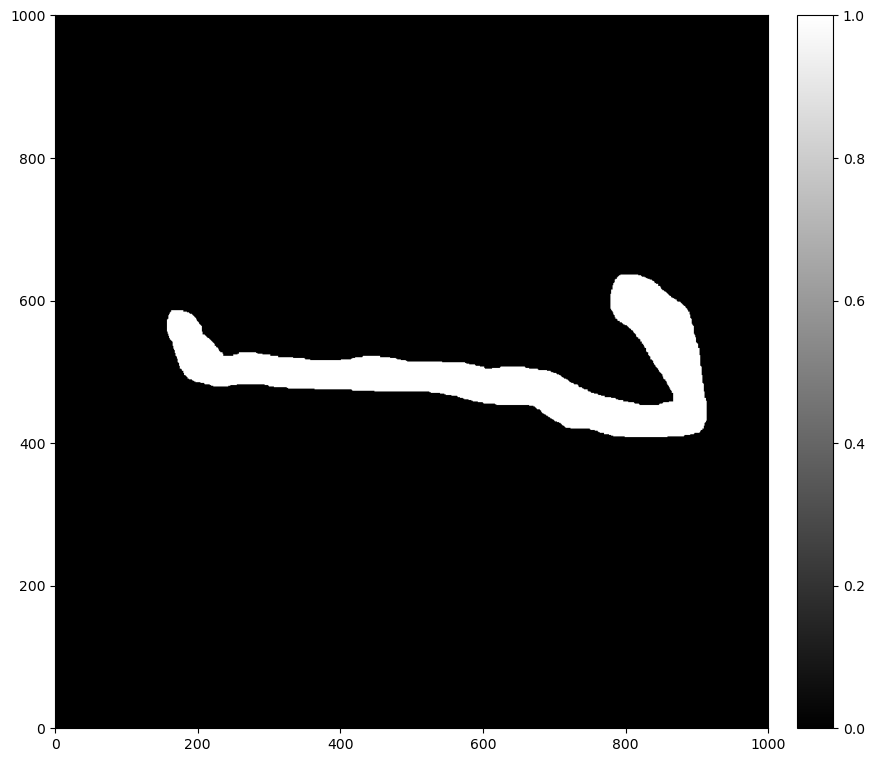

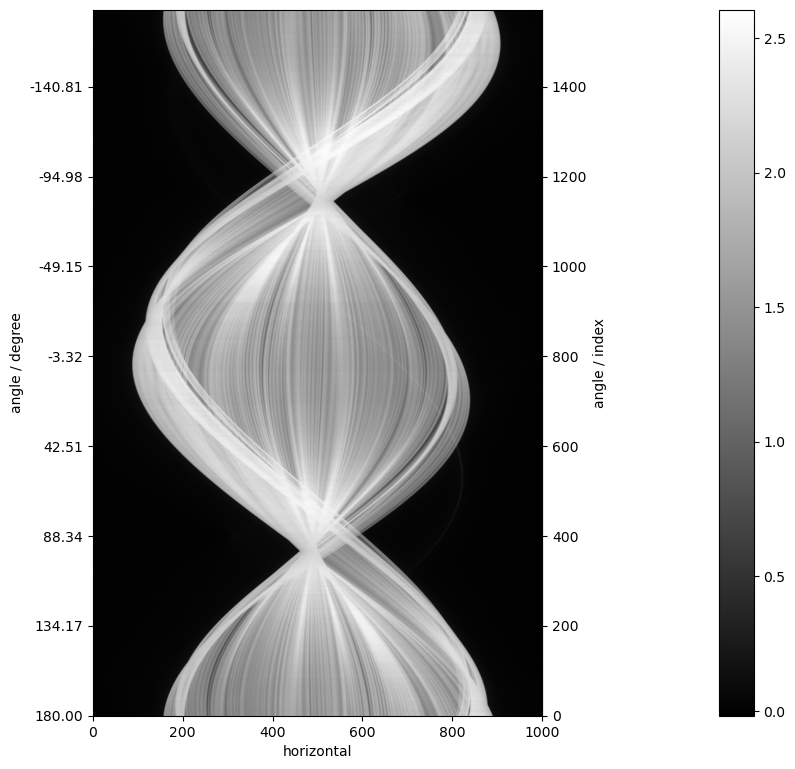

In [ ]:
show2D(mask)
show2D(data)

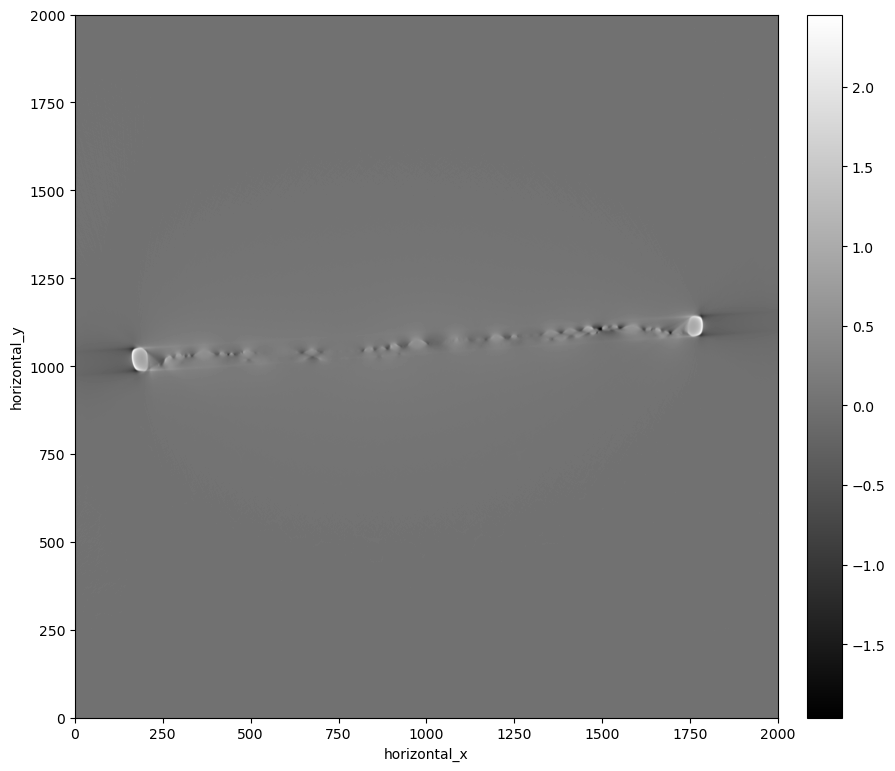

In [93]:
data.reorder('tigre')
fdk = FDK(data)
recon = fdk.run(verbose=0)
show2D(recon)

In [ ]:
mask = np.array(mask,dtype=bool)
# show2D(mask)

In [ ]:
recon

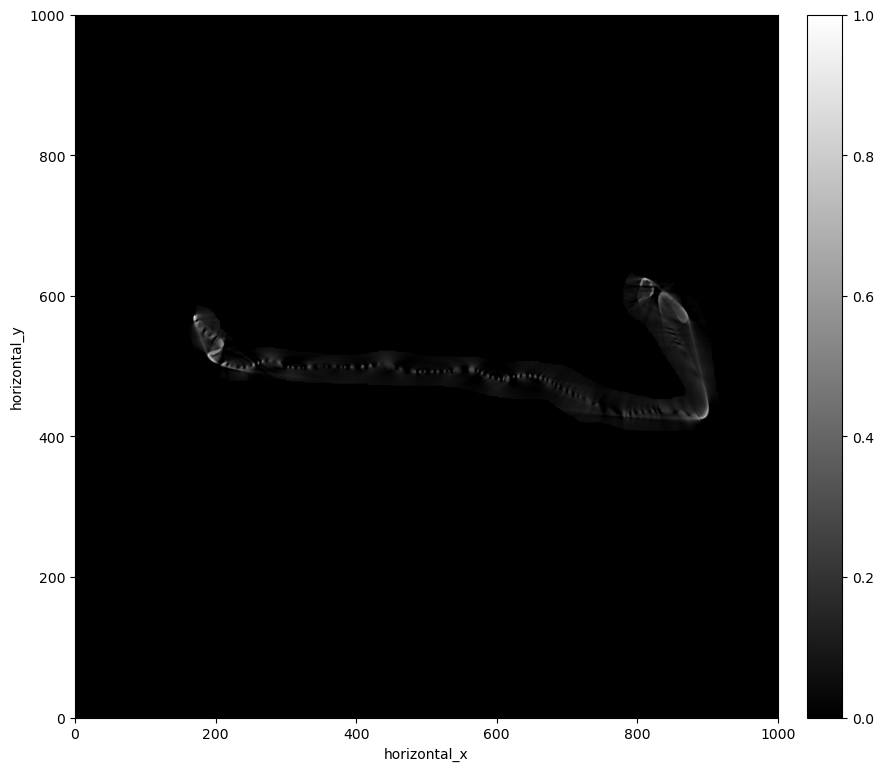

In [ ]:
recon_arr = mask * np.clip(recon.as_array(),a_min=0,a_max=1)
recon_clipped = ImageData(array=recon_arr,geometry=ig)
show2D(recon_clipped)

In [21]:
!nvidia-smi

Mon Feb 19 22:09:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:37:00.0 Off |                    0 |
| N/A   56C    P0              41W / 250W |    942MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
A = ProjectionOperator(ig, ag)
F = L2NormSquared(b=data)
K = A
G = IndicatorBox(lower=0.0, upper=1.0)
algo = PDHG(
    initial=recon_clipped, operator=K,
    f=F, g=G, max_iteration=1000,
    update_objective_interval=20
)
algo.run(100,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.20898e+06
       20       1000         0.323          2.17969e+05
       40       1000         0.323          2.11462e+05
       60       1000         0.322          2.07783e+05
       80       1000         0.321          2.06450e+05
      100       1000         0.321          2.05521e+05
-------------------------------------------------------
      100       1000         0.321          2.05521e+05
Stop criterion has been reached.



In [ ]:
algo.run(100,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
      100       1000         0.409          7.17453e+05
      120       1000         0.409          7.16881e+05
      140       1000         0.408          7.16249e+05
      160       1000         0.409          7.15495e+05
      180       1000         0.409          7.15250e+05
      200       1000         0.410          7.14917e+05
-------------------------------------------------------
      200       1000         0.410          7.14917e+05
Stop criterion has been reached.



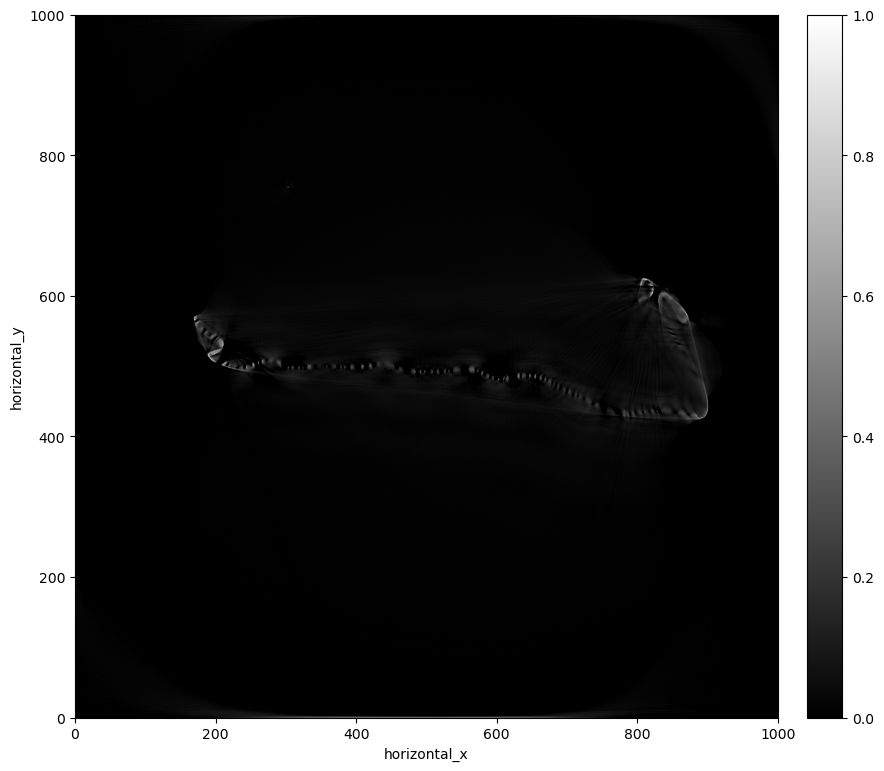

In [ ]:
show2D(algo.solution)

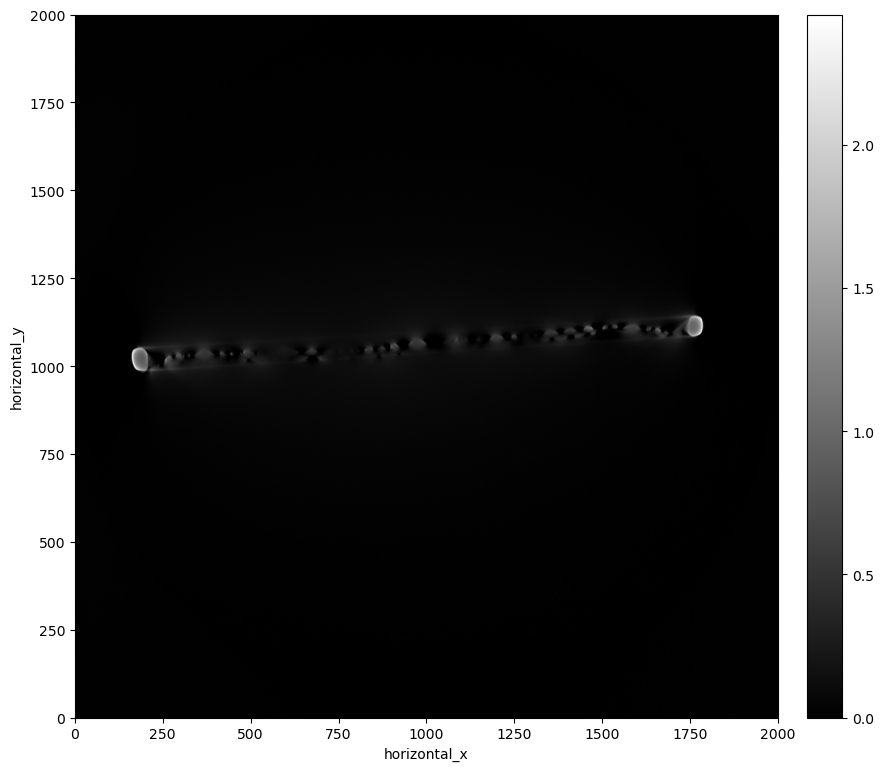

In [94]:
# recon_arr = mask * np.clip(recon.as_array(),a_min=0,a_max=1)
# recon_clipped = ImageData(array=recon_arr,geometry=ig)

recon_arr = np.clip(recon.as_array(),a_min=0,a_max=100)
recon_clipped = ImageData(array=recon_arr,geometry=ig)
show2D(recon_clipped)

In [97]:
A2 = ProjectionOperator(ig, ag, 'Siddon', device='gpu')
# path_lengths = A2.direct(algo.solution)
path_lengths = A2.direct(recon_clipped)

Text(0.5, 1.0, 'absorption vs path_lengths')

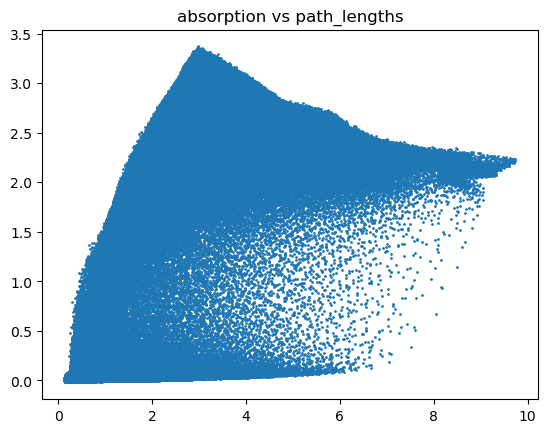

In [98]:
plt.plot(path_lengths.as_array().flatten(),data.as_array().flatten(),'.',markersize=2)
plt.title('absorption vs path_lengths')

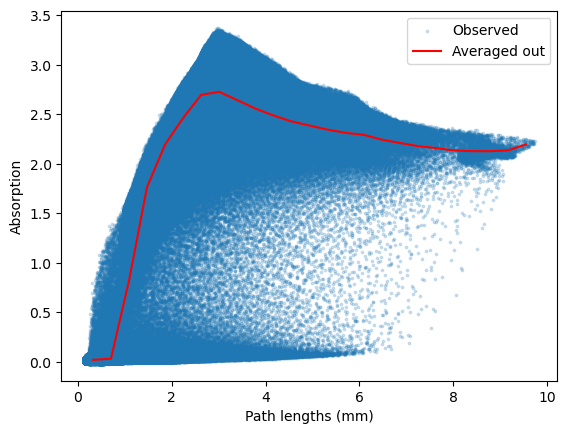

In [99]:
if True:
    x = np.array(path_lengths.as_array().flatten())
    y = np.array(data.as_array().flatten())
    num_bins = 25
    bin_edges = np.linspace(x.min(), x.max(), num_bins+1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_indices = np.digitize(x, bin_edges)
    bin_means = np.array([y[bin_indices == i].mean() for i in range(1, len(bin_edges))])
    plt.scatter(x, y, alpha=0.2, label='Observed',s=3)
    # yy = (1+bin_centers/np.max(bin_centers)) * bin_means
    # yy = yy/np.max(yy)*data.max()
    yy = bin_means
    plt.plot(bin_centers, yy, color='red', label='Averaged out')
    plt.xlabel('Path lengths (mm)')
    plt.ylabel('Absorption')
    plt.title('')
    plt.legend()
    plt.show()

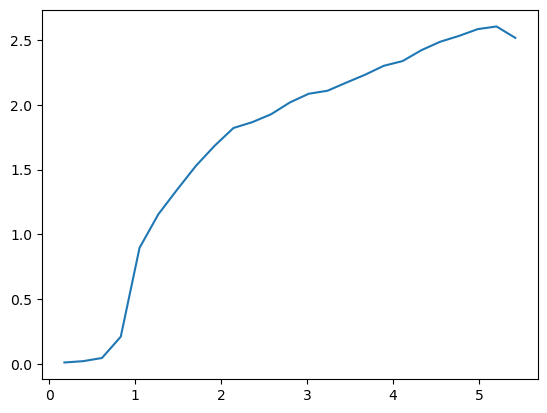

In [ ]:
yy = (1+bin_centers/np.max(bin_centers)) * bin_means
yy = yy/np.max(yy)*data.max()
plt.plot(bin_centers,yy)

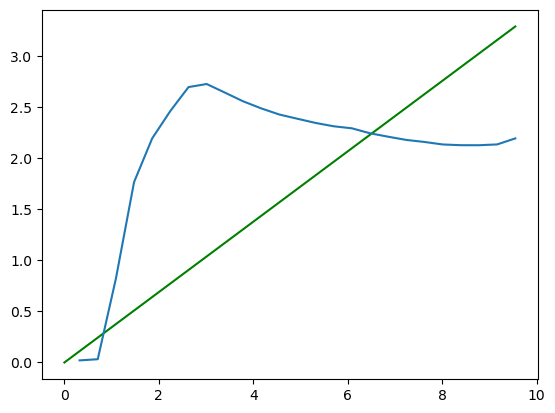

In [100]:
def f(x, c):
    return c*x

x2 = np.hstack(([0],bin_centers))
y2 = np.hstack(([0],yy))

popt_f, pcov = curve_fit(f, x2, y2)
y_lin = f(x2,popt_f[0])
plt.plot(x2, y_lin, color='green', label='line_fit')
plt.plot(bin_centers,yy)
plt.show()

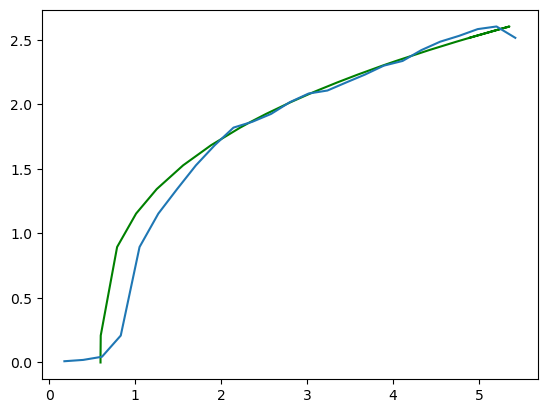

In [ ]:
# def g(x, a,b):
#     return a*x**3+b

# x2 = np.hstack(([0],bin_centers))
# y2 = np.hstack(([0],yy))

# popt_g, pcov = curve_fit(g, y2, x2)
# x_fit = g(y2,popt_g[0],popt_g[1])
# plt.plot(x_fit, y2, color='green', label='line_fit')
# plt.plot(bin_centers,yy)
# plt.show()

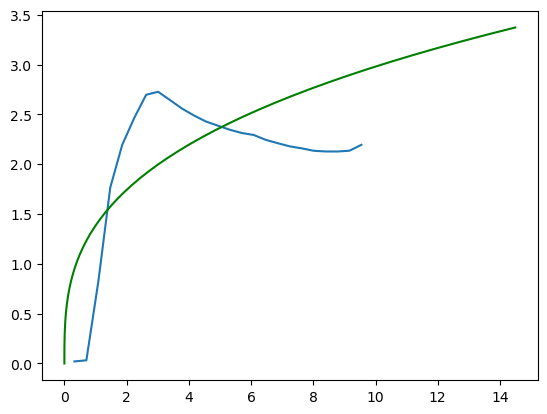

[0.37799418]


In [101]:
def g(x, a):
    return a*x**3+0*x

x2 = np.hstack(([0],bin_centers))
y2 = np.hstack(([0],yy))

popt_g, pcov = curve_fit(g, y2, x2)
# x_fit = g(y2,*popt_g)
pp = np.linspace(0,data.max())
x_fit = g(pp,*popt_g)
plt.plot(bin_centers,yy)
plt.plot(x_fit, pp, color='green', label='line_fit')
# plt.ylim(0,3)
plt.show()
print(popt_g)

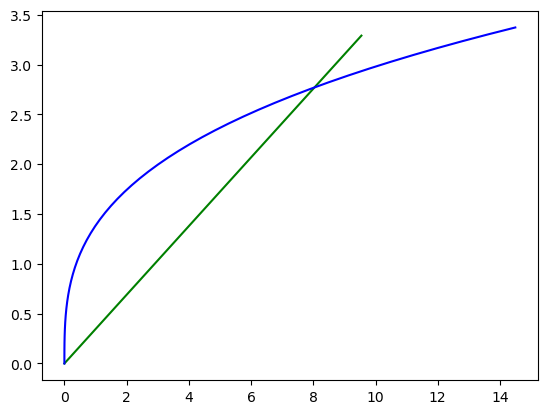

In [105]:
plt.plot(x2, y_lin, color='green', label='line_fit')
plt.plot(x_fit, pp, color='blue', label='line_fit')

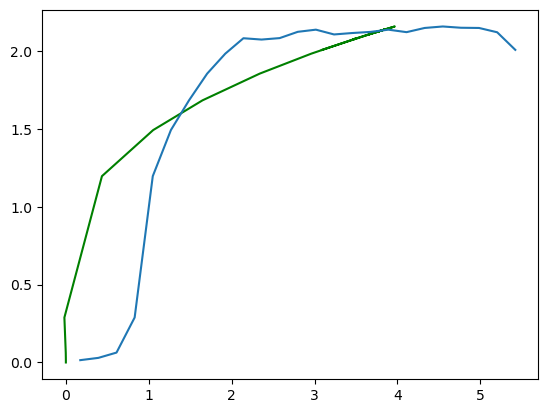

[ 0.57045157 -0.37859657]


In [ ]:
def g(x, a,b):
    return a*x**3 + b*x**2

x2 = np.hstack(([0],bin_centers))
y2 = np.hstack(([0],yy))

popt_g, pcov = curve_fit(g, y2, x2)
x_fit = g(y2,popt_g[0],popt_g[1])
plt.plot(x_fit, y2, color='green', label='line_fit')
plt.plot(bin_centers,yy)
plt.show()
print(popt_g)

Text(0.5, 1.0, 'absorption_new vs absorption_old')

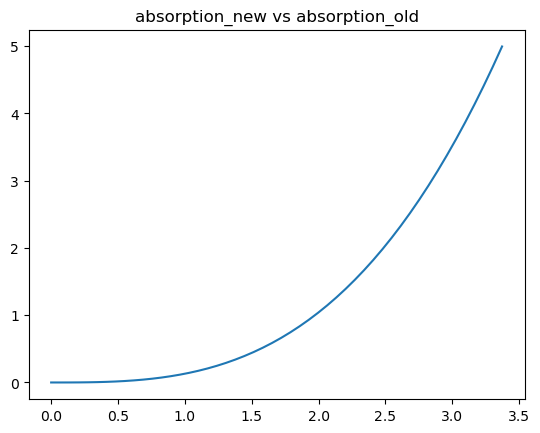

In [106]:
yylin = np.linspace(0,data.max())
# gglin = g(yylin,popt_g[0],popt_g[1])
gglin = g(yylin,*popt_g)
fflin = f(gglin,popt_f[0])
plt.plot(yylin,fflin)
plt.title('absorption_new vs absorption_old')

In [107]:
# gg = g(data.as_array(),popt_g[0],popt_g[1])
gg = g(data.as_array(),*popt_g)
ff = f(gg,popt_f[0])
data_bhc = AcquisitionData(array=np.array(ff,dtype='float32'),geometry=ag)

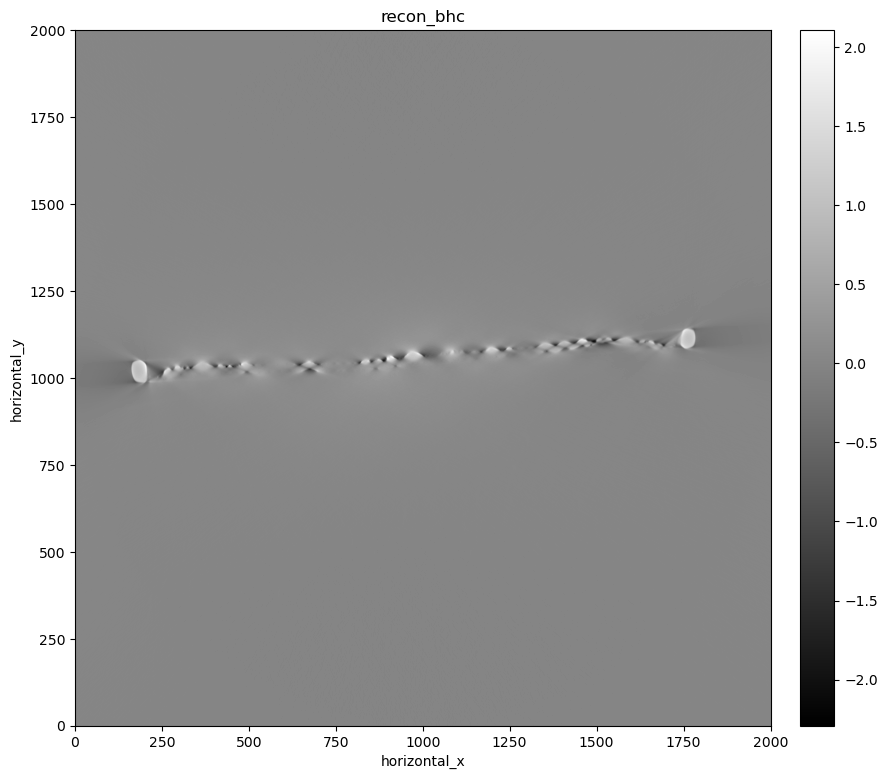

In [108]:
data.reorder('tigre')
fdk2 = FDK(data_bhc)
recon_bhc = fdk2.run(verbose=0)
show2D(recon_bhc,'recon_bhc')

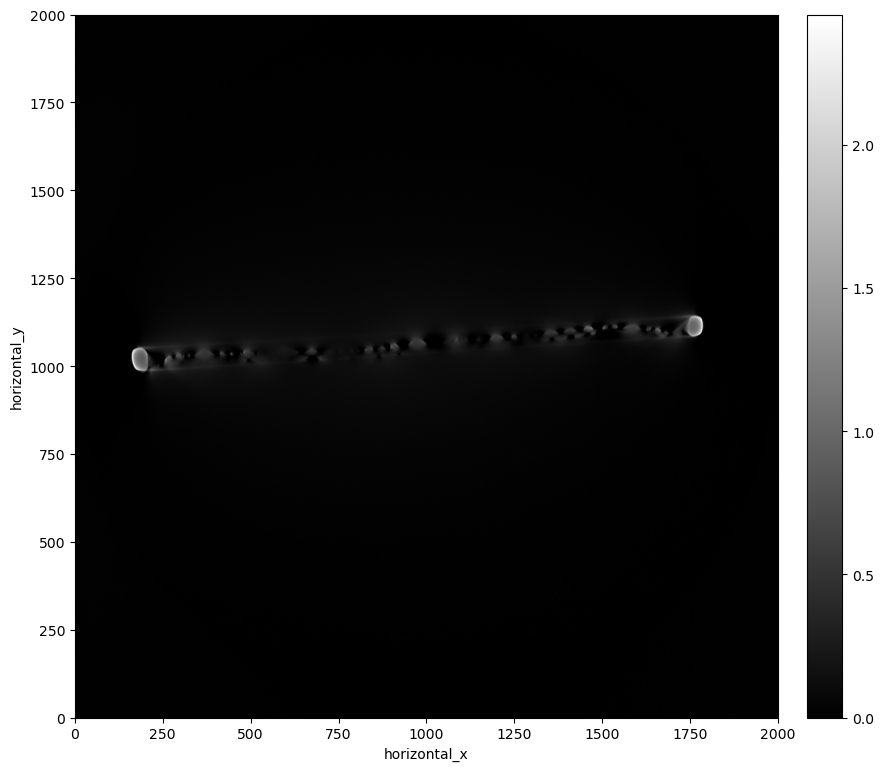

In [110]:
recon_arr = np.clip(recon.as_array(),a_min=0,a_max=100)
recon_clipped = ImageData(array=recon_arr,geometry=ig)
show2D(recon_clipped)

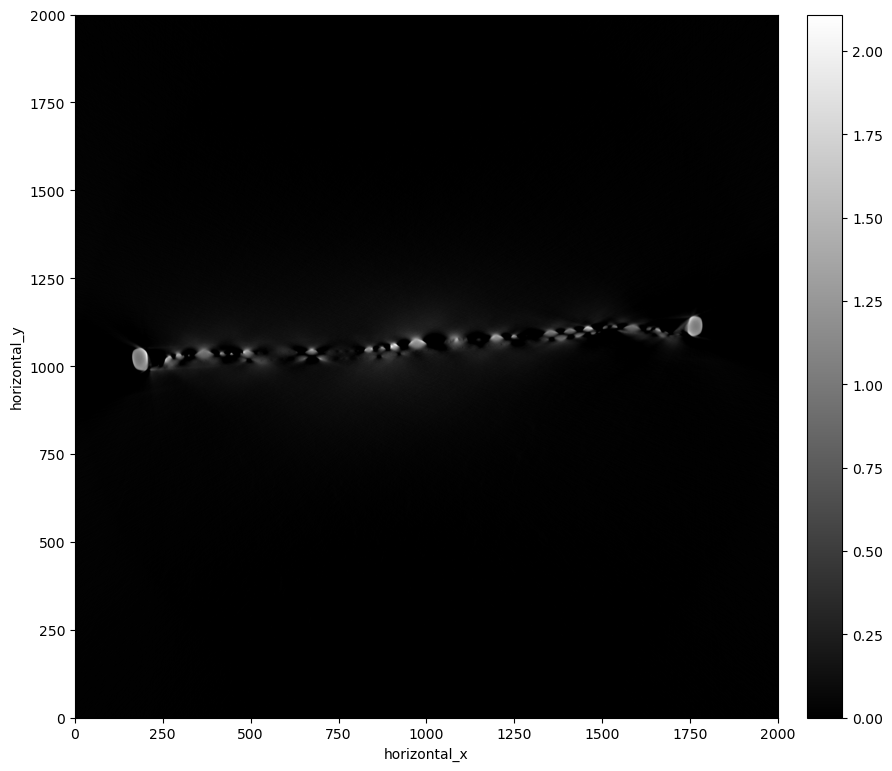

In [111]:
recon_arr = np.clip(recon_bhc.as_array(),a_min=0,a_max=100)
recon_clipped = ImageData(array=recon_arr,geometry=ig)
show2D(recon_clipped)

In [ ]:
A3 = ProjectionOperator(ig,ag,device='gpu')
F = LeastSquares(A3, data_bhc)
G = IndicatorBox(lower=0.0)
myFISTANN = FISTA(f=F, 
                  g=G, 
                  initial=recon_bhc, 
                  max_iteration=1000,
                  update_objective_interval = 10)

In [ ]:
myFISTANN.run(100, verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
      100       1000         0.280          9.89273e+04


      110       1000         0.281          9.89079e+04
      120       1000         0.281          9.88920e+04
      130       1000         0.280          9.88791e+04
      140       1000         0.280          9.88686e+04
      150       1000         0.281          9.88600e+04
      160       1000         0.281          9.88528e+04
      170       1000         0.280          9.88466e+04
      180       1000         0.280          9.88408e+04
      190       1000         0.280          9.88352e+04
      200       1000         0.280          9.88300e+04
-------------------------------------------------------
      200       1000         0.280          9.88300e+04
Stop criterion has been reached.



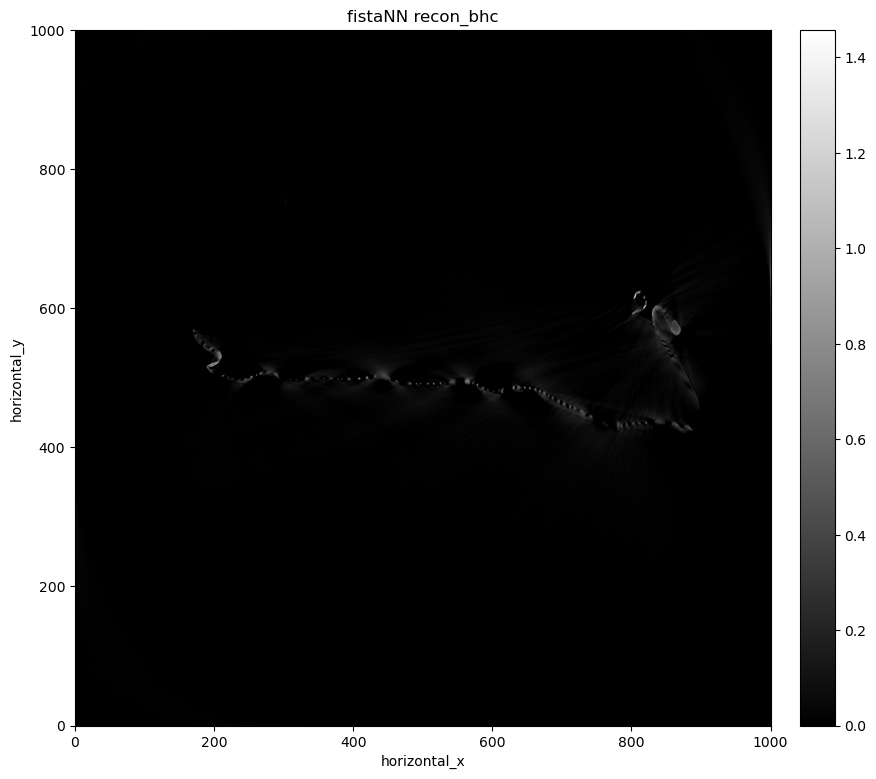

In [ ]:
show2D(myFISTANN.solution,'fistaNN recon_bhc')

In [ ]:
K = A3
F = L2NormSquared(b=data_bhc)
alpha = 1
# G = alpha*L1Norm()
# G = alpha * TotalVariation(max_iteration=100, lower=0.)
G = alpha * FGP_TV(max_iteration=100, nonnegativity = True, device = 'gpu')

pdhg_l1 = PDHG(f = F, g = G, operator = K, 
            max_iteration = 1000,
            update_objective_interval = 10)

/zhome/07/f/169104/miniconda3/envs/bsc/lib/python3.10/site-packages/cil/optimisation/algorithms/PDHG.py:408: UserWarning: Convergence criterion of PDHG for scalar step-sizes is not satisfied.
  warnings.warn("Convergence criterion of PDHG for scalar step-sizes is not satisfied.")


In [ ]:
pdhg_l1.run(100,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.09812e+06


       10       1000         0.283          1.36046e+05
       20       1000         0.278          1.19724e+05
       30       1000         0.277          1.11555e+05
       40       1000         0.276          1.07133e+05
       50       1000         0.275          1.04560e+05
       60       1000         0.275          1.03627e+05
       70       1000         0.275          1.02502e+05
       80       1000         0.274          1.01987e+05
       90       1000         0.274          1.01544e+05
      100       1000         0.274          1.01254e+05
-------------------------------------------------------
      100       1000         0.274          1.01254e+05
Stop criterion has been reached.



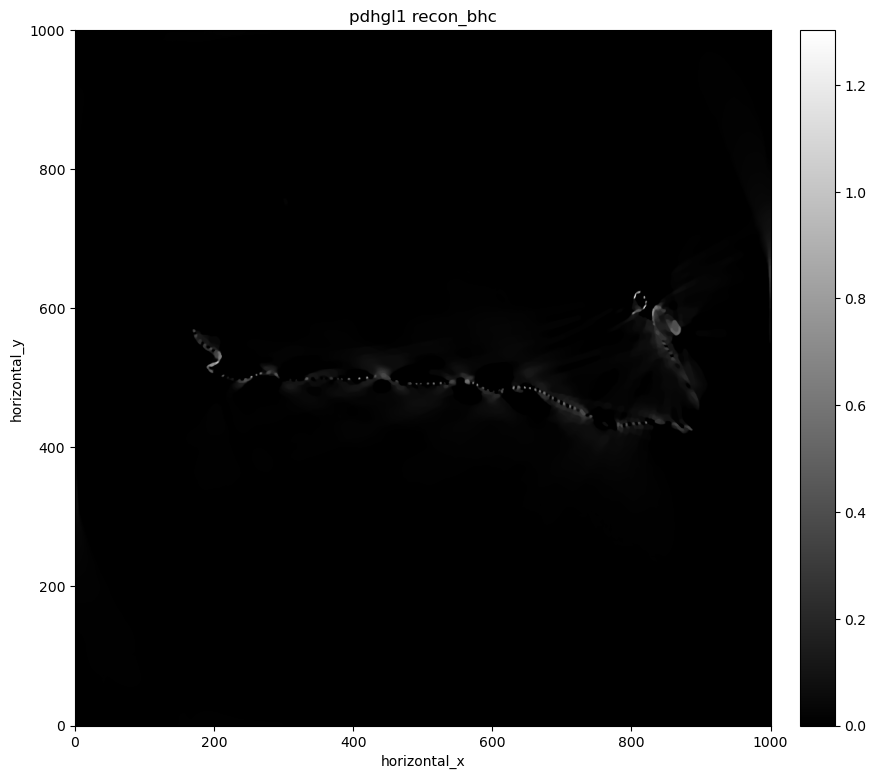

In [ ]:
show2D(pdhg_l1.solution,'pdhgl1 recon_bhc')

In [ ]:
# Define BlockFunction F
alpha_tv = 0.01
f1 = alpha_tv * MixedL21Norm()
f2 = 0.5 * L2NormSquared(b=data_bhc)
F = BlockFunction(f1, f2)

# Define BlockOperator K
Grad = GradientOperator(ig)
K = BlockOperator(Grad, A)

# Define Function G
G = IndicatorBox(lower=0)


# Setup and run PDHG
pdhg_tv_explicit = PDHG(f = F, g = G, operator = K,
            max_iteration = 1000,
            update_objective_interval = 10)

In [ ]:
pdhg_tv_explicit.run(100,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     


        0       1000         0.000          5.49062e+05
       10       1000         0.293          6.63503e+04
       20       1000         0.292          5.89727e+04
       30       1000         0.291          5.50139e+04
       40       1000         0.292          5.29351e+04
       50       1000         0.292          5.19734e+04
       60       1000         0.292          5.14858e+04
       70       1000         0.292          5.09343e+04
       80       1000         0.292          5.06708e+04
       90       1000         0.292          5.04196e+04
      100       1000         0.292          5.02976e+04
-------------------------------------------------------
      100       1000         0.292          5.02976e+04
Stop criterion has been reached.



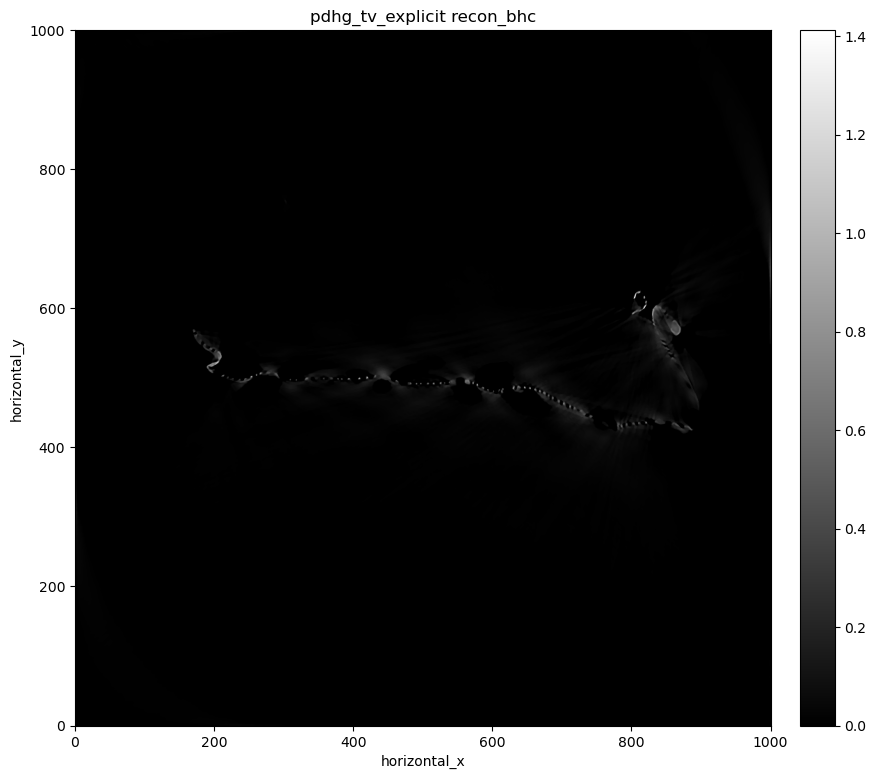

In [ ]:
show2D(pdhg_tv_explicit.solution,'pdhg_tv_explicit recon_bhc')

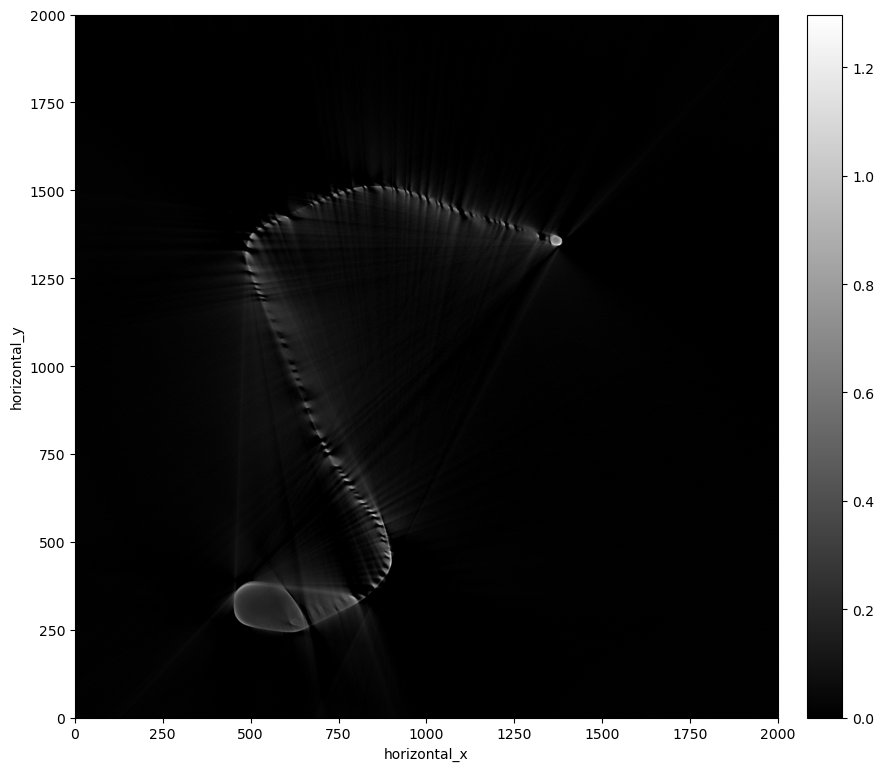

In [56]:
# recon_arr = mask * np.clip(recon.as_array(),a_min=0,a_max=1)
# recon_clipped = ImageData(array=recon_arr,geometry=ig)

recon_arr = np.clip(recon_bhc.as_array(),a_min=0,a_max=100)
recon_clipped = ImageData(array=recon_arr,geometry=ig)
show2D(recon_clipped)


Text(0.5, 1.0, 'absorption vs path_lengths')

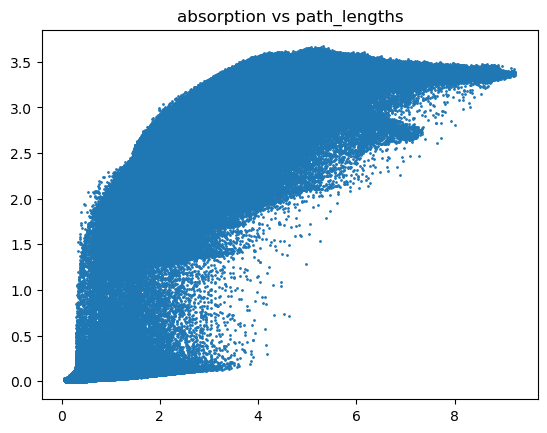

In [86]:

A2 = ProjectionOperator(ig, ag, device='gpu')
# path_lengths = A2.direct(algo.solution)
path_lengths = A2.direct(recon_clipped)
plt.plot(path_lengths.as_array().flatten(),data.as_array().flatten(),'.',markersize=2)
plt.title('absorption vs path_lengths')

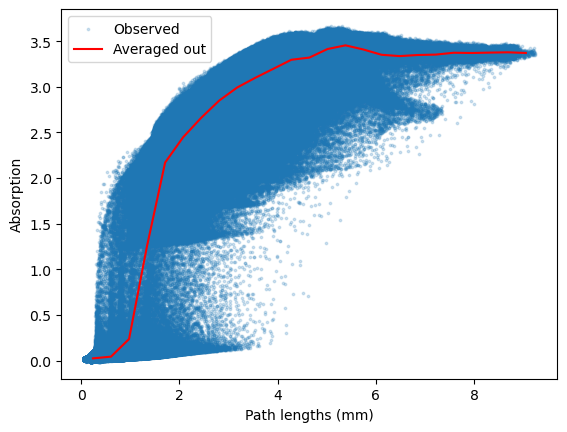

In [87]:
if True:
    x = np.array(path_lengths.as_array().flatten())
    y = np.array(data.as_array().flatten())
    num_bins = 25
    bin_edges = np.linspace(x.min(), x.max(), num_bins+1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_indices = np.digitize(x, bin_edges)
    bin_means = np.array([y[bin_indices == i].mean() for i in range(1, len(bin_edges))])
    plt.scatter(x, y, alpha=0.2, label='Observed',s=3)
    # yy = (1+bin_centers/np.max(bin_centers)) * bin_means
    # yy = yy/np.max(yy)*data.max()
    yy = bin_means
    plt.plot(bin_centers, yy, color='red', label='Averaged out')
    plt.xlabel('Path lengths (mm)')
    plt.ylabel('Absorption')
    plt.title('')
    plt.legend()
    plt.show()

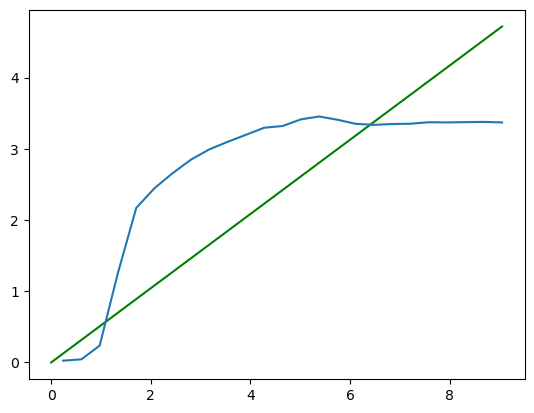

In [59]:
def f(x, c):
    return c*x

x2 = np.hstack(([0],bin_centers))
y2 = np.hstack(([0],yy))

popt_f, pcov = curve_fit(f, x2, y2)
y_lin = f(x2,popt_f[0])
plt.plot(x2, y_lin, color='green', label='line_fit')
plt.plot(bin_centers,yy)
plt.show()

/tmp/ipykernel_13610/505928581.py:7: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_g, pcov = curve_fit(g, y2, x2)


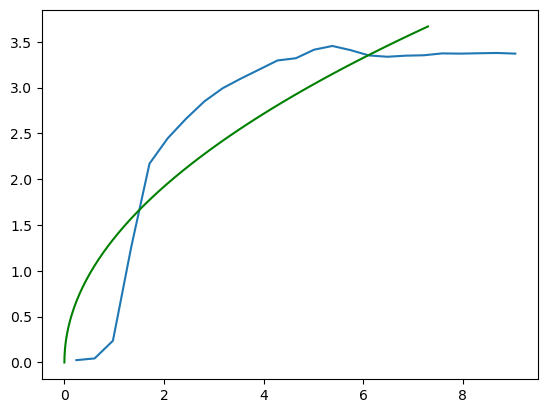

[0.54279085 1.        ]


In [77]:
def g(x, a,b):
    return a*x**2

x2 = np.hstack(([0],bin_centers))
y2 = np.hstack(([0],yy))

popt_g, pcov = curve_fit(g, y2, x2)
# x_fit = g(y2,*popt_g)
pp = np.linspace(0,data.max())
x_fit = g(pp,*popt_g)
plt.plot(bin_centers,yy)
plt.plot(x_fit, pp, color='green', label='line_fit')
# plt.ylim(0,3)
plt.show()
print(popt_g)

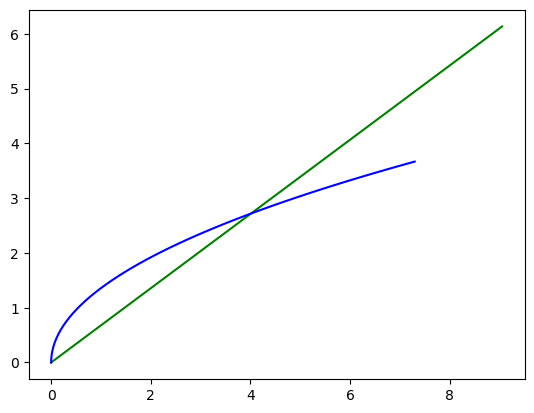

In [78]:

plt.plot(x2, 1.3*y_lin, color='green', label='line_fit')
plt.plot(x_fit, pp, color='blue', label='line_fit')


Text(0.5, 1.0, 'absorption_new vs absorption_old')

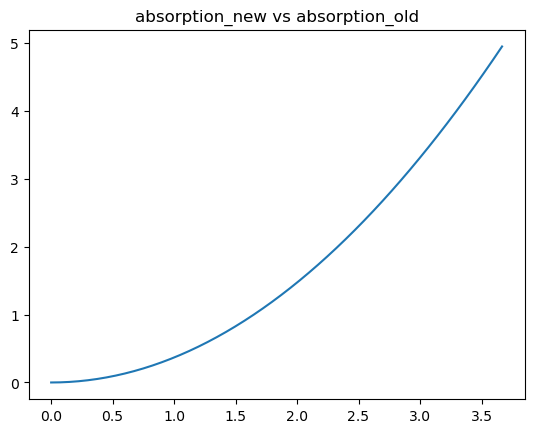

In [79]:
yylin = np.linspace(0,data.max())
# gglin = g(yylin,popt_g[0],popt_g[1])
gglin = g(yylin,*popt_g)
fflin = f(gglin,1.3*popt_f[0])
plt.plot(yylin,fflin)
plt.title('absorption_new vs absorption_old')

In [80]:
# gg = g(data.as_array(),popt_g[0],popt_g[1])
gg = g(data.as_array(),*popt_g)
ff = f(gg,1.3*popt_f[0])
data_bhc = AcquisitionData(array=np.array(ff,dtype='float32'),geometry=ag)

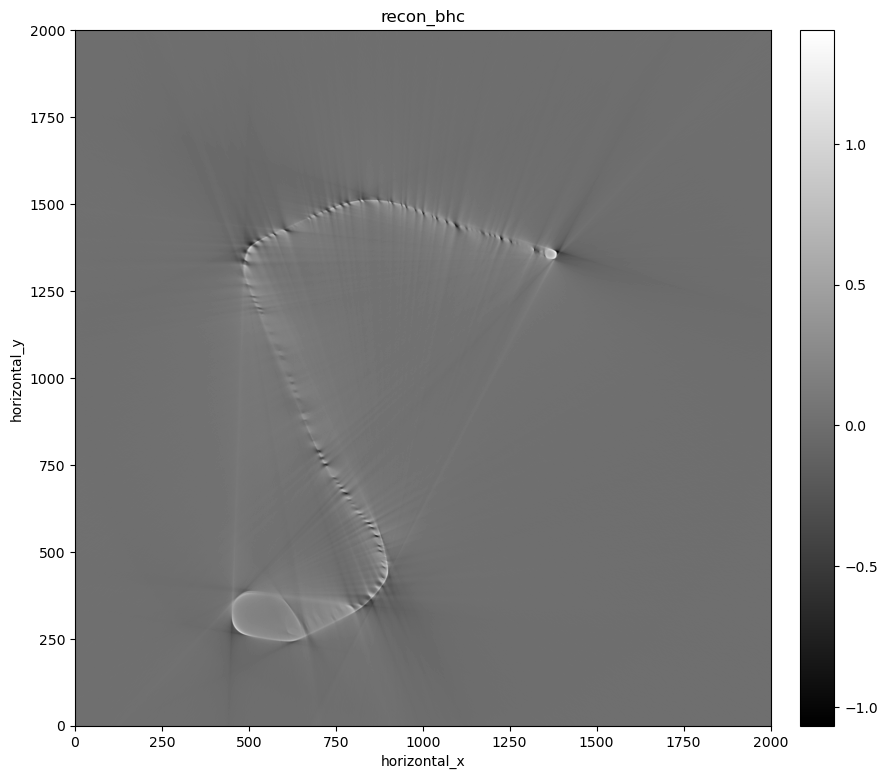

In [81]:

data.reorder('tigre')
fdk2 = FDK(data_bhc)
recon_bhc = fdk2.run(verbose=0)
show2D(recon_bhc,'recon_bhc')

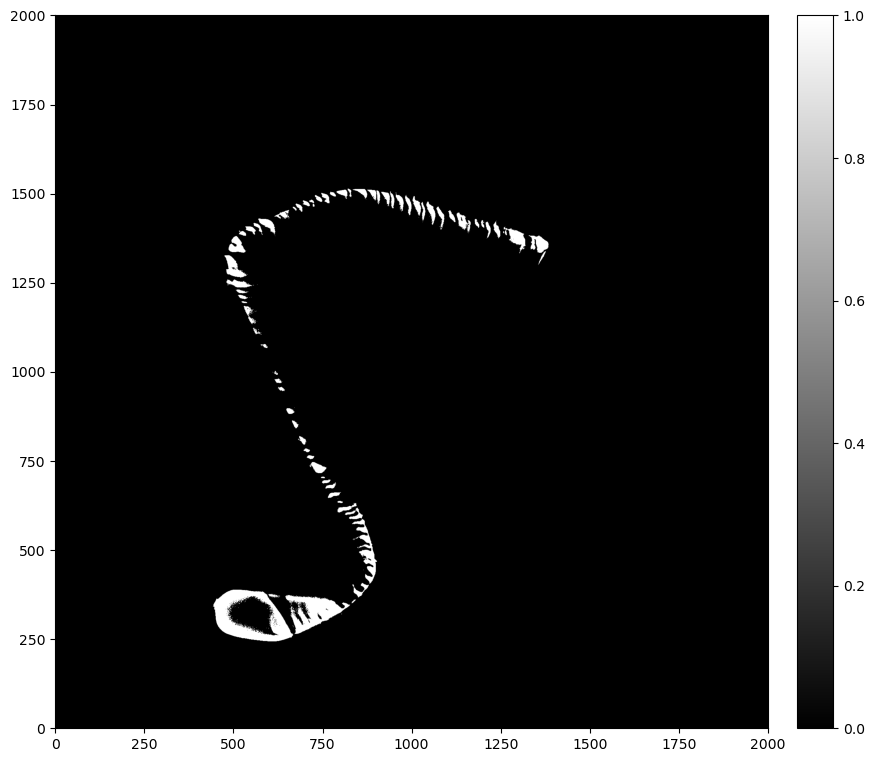

In [85]:
recon_segmented = recon_bhc > 0.22
show2D(recon_bhc > 0.22)